In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

import torch
from transformers import *
from fastai2.text.all import *

from blurr.data.all import *
from blurr.modeling.core import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
# full
# squad_df = pd.read_csv('./data/task-question-answering/squad_cleaned.csv'); len(squad_df)

# sample
squad_df = pd.read_csv('./squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible
0,56be85543aeaaa14008c9063,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start': [269]}",train,in the late 1990s,False
1,56be85543aeaaa14008c9065,Beyoncé,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five G...",What areas did Beyonce compete in when she was growing up?,"{'text': ['singing and dancing'], 'answer_start': [207]}",train,singing and dancing,False


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_model_cls = BertForQuestionAnswering

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               model_cls=hf_model_cls)

# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
#                                                                                task=HF_TASKS_AUTO.ForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
#                                                                                task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
squad_df = squad_df.apply(partial(pre_process_squad, hf_arch=hf_arch, hf_tokenizer=hf_tokenizer), axis=1)

In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,id,title,context,question,answers,ds_type,answer_text,is_impossible,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
214,56be97c73aeaaa14008c912a,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Beyonce would take a break from music in which year?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], beyonce, would, take, a, break, from, music, in, which, year, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, ballet...",99,23,24
215,56be97c73aeaaa14008c912b,Beyoncé,"Beyoncé announced a hiatus from her music career in January 2010, heeding her mother's advice, ""to live life, to be inspired by things again"". During the break she and her father parted ways as business partners. Beyoncé's musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.",Which year did Beyonce and her father part business ways?,"{'text': ['2010'], 'answer_start': [60]}",train,2010,False,"[[CLS], which, year, did, beyonce, and, her, father, part, business, ways, ?, [SEP], beyonce, announced, a, hiatus, from, her, music, career, in, january, 2010, ,, hee, ##ding, her, mother, ', s, advice, ,, "", to, live, life, ,, to, be, inspired, by, things, again, "", ., during, the, break, she, and, her, father, parted, ways, as, business, partners, ., beyonce, ', s, musical, break, lasted, nine, months, and, saw, her, visit, multiple, european, cities, ,, the, great, wall, of, china, ,, the, egyptian, pyramid, ##s, ,, australia, ,, english, music, festivals, and, various, museums, and, b...",99,23,24


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'

blocks = (
    HF_TextBlock(hf_arch, hf_tokenizer, 
                 hf_batch_tfm=HF_QABatchTransform(hf_arch, hf_tokenizer), 
                 max_length=max_seq_len, truncation=trunc_strat, 
                 tok_kwargs={ 'return_special_tokens_mask': True }), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,start/end,answer
0,"what was frederic prone to during early childhood as a result of his slight build? in october 1810, six months after fryderyk's birth, the family moved to warsaw, where his father acquired a post teaching french at the warsaw lyceum, then housed in the saxon palace. fryderyk lived with his family in the palace grounds. the father played the flute and violin ; the mother played the piano and gave lessons to boys in the boarding house that the chopins kept. chopin was of slight build, and even in early childhood was prone to illnesses.","(114, 115)",illnesses
1,"what is the latest term used to describe beyonce fans? the bey hive is the name given to beyonce's fan base. fans were previously titled "" the beyontourage "", ( a portmanteau of beyonce and entourage ). the name bey hive derives from the word beehive, purposely misspelled to resemble her first name, and was penned by fans after petitions on the online social networking service twitter and online news reports during competitions.","(14, 16)",bey hive


### Training

Here we create a question/answer specific subclass of `HF_BaseModelCallback` in order to get all the start and end prediction.  We also add here a new loss function that can handle multiple targets

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """We need to return everything from the model for question/answer tasks"""
    def after_pred(self): self.learn.pred = self.pred

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


In [ ]:
model = HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.blurr_summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=7.585775847473997e-07)

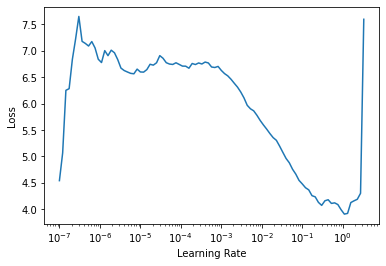

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.711932,2.651879,00:02
1,3.406733,2.058545,00:02
2,2.632739,1.957371,00:02


### Showing results

Below we'll add in additional functionality to more intuitively show the results of our model.

In [ ]:
#export
@typedispatch
def show_results(x:HF_QuestionAnswerInput, y, samples, outs, learner=None, skip_special_tokens=True, 
                 ctxs=None, max_n=6, **kwargs):     
    # grab tokenizer
    hf_textblock_tfm = learner.dls.tfms[0]
    hf_tokenizer = hf_textblock_tfm.hf_tokenizer
    
    res = L()
    for sample, input_ids, start, end, pred in zip(samples, x[0], *y, outs):
        txt = sample[0]
        ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[start:end]
        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[int(pred[0]):int(pred[1])]
        
        res.append((txt,
                    (start.item(),end.item()), hf_tokenizer.convert_tokens_to_string(ans_toks),
                    (int(pred[0]),int(pred[1])), hf_tokenizer.convert_tokens_to_string(pred_ans_toks)))

    df = pd.DataFrame(res, columns=['text', 'start/end', 'answer', 'pred start/end', 'pred answer'])
    display_df(df[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, skip_special_tokens=True, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"what was the degree of frederic's association with political insurrection? in his native poland, in france, where he composed most of his works, and beyond, chopin's music, his status as one of music's earliest superstars, his association ( if only indirect ) with political insurrection, his love life and his early death have made him, in the public consciousness, a leading symbol of the romantic era. his works remain popular, and he has been the subject of numerous films and biographies of varying degrees of historical accuracy.","(56, 57)",indirect,"(56, 57)",indirect
1,"how was the suit settled? the release of a video - game starpower : beyonce was cancelled after beyonce pulled out of a $ 100 million with gatefive who alleged the cancellation meant the sacking of 70 staff and millions of pounds lost in development. it was settled out of court by her lawyers in june 2013 who said that they had cancelled because gatefive had lost its financial backers. beyonce also has had deals with american express, nintendo ds and l'oreal since the age of 18.","(56, 59)",out of court,"(56, 81)",out of court by her lawyers in june 2013 who said that they had cancelled because gatefive had lost its financial backers


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.blurr_predict(inf_df.iloc[0])

(('11', '12'),
 tensor([11]),
 tensor([[7.3021e-08, 2.0943e-07, 1.0810e-08, 3.1980e-08, 2.0152e-08, 1.6194e-08,
          7.9661e-10, 7.3024e-08, 1.4909e-04, 9.1756e-06, 4.2849e-04, 9.9930e-01,
          2.9859e-05, 9.7572e-07, 9.3954e-06, 7.3746e-08, 3.5214e-05, 3.3559e-05,
          7.7704e-08, 7.3545e-06, 5.9468e-07, 7.3009e-08, 7.3343e-08, 4.6143e-10,
          5.1648e-10, 4.8182e-10, 4.7790e-10, 4.9292e-10, 5.0651e-10, 5.0436e-10,
          4.7118e-10, 4.8288e-10, 5.0259e-10, 4.9650e-10, 4.4875e-10, 4.4326e-10,
          4.6643e-10, 4.6361e-10, 4.4272e-10, 4.4284e-10, 4.4960e-10, 4.6260e-10,
          4.7463e-10, 4.6140e-10, 4.8058e-10, 4.8377e-10, 4.7543e-10, 4.6814e-10,
          4.7134e-10, 4.7154e-10, 4.9262e-10, 4.8325e-10, 4.7951e-10, 4.9162e-10,
          5.1543e-10, 5.1312e-10, 4.9974e-10, 4.7989e-10, 4.7980e-10, 5.1580e-10,
          5.0621e-10, 4.7334e-10, 4.6308e-10, 4.7710e-10, 5.0421e-10, 4.7494e-10,
          4.5583e-10, 4.6301e-10, 4.6859e-10, 4.9702e-10, 4.6953e-10

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp = test_dl.one_batch()[0]['input_ids']
probs, _, preds = learn.get_preds(dl=test_dl, with_input=False, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp.tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.838327,1.711541,00:08
1,1.544638,1.497579,00:08
2,1.359908,1.461344,00:08


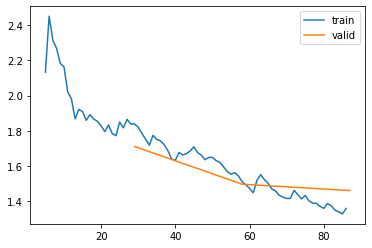

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2)

,text,start/end,answer,pred start/end,pred answer
0,"what was the degree of frederic's association with political insurrection? in his native poland, in france, where he composed most of his works, and beyond, chopin's music, his status as one of music's earliest superstars, his association ( if only indirect ) with political insurrection, his love life and his early death have made him, in the public consciousness, a leading symbol of the romantic era. his works remain popular, and he has been the subject of numerous films and biographies of varying degrees of historical accuracy.","(56, 57)",indirect,"(56, 57)",indirect
1,"when did she stop using her father as a manager? beyonce announced a hiatus from her music career in january 2010, heeding her mother's advice, "" to live life, to be inspired by things again "". during the break she and her father parted ways as business partners. beyonce's musical break lasted nine months and saw her visit multiple european cities, the great wall of china, the egyptian pyramids, australia, english music festivals and various museums and ballet performances.","(46, 49)",during the break,"(46, 24)",


In [ ]:
learn.blurr_predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[1.3491e-07, 4.7744e-07, 4.6159e-08, 3.6362e-08, 1.8871e-08, 1.1658e-07,
          8.7196e-09, 1.3492e-07, 1.5896e-05, 2.9174e-06, 1.9688e-05, 2.7406e-05,
          4.7958e-07, 1.5575e-03, 9.9837e-01, 3.1343e-07, 2.9248e-07, 3.8377e-07,
          1.5405e-08, 2.0981e-07, 1.5375e-07, 1.3489e-07, 1.3513e-07, 1.5317e-09,
          1.7299e-09, 1.6294e-09, 1.6358e-09, 1.6192e-09, 1.6529e-09, 1.5747e-09,
          1.5758e-09, 1.5628e-09, 1.7079e-09, 1.7116e-09, 1.5565e-09, 1.5579e-09,
          1.5767e-09, 1.5587e-09, 1.5491e-09, 1.5587e-09, 1.5036e-09, 1.5191e-09,
          1.5627e-09, 1.5460e-09, 1.5445e-09, 1.5707e-09, 1.5177e-09, 1.5236e-09,
          1.5394e-09, 1.5063e-09, 1.6607e-09, 1.5858e-09, 1.5757e-09, 1.5989e-09,
          1.6022e-09, 1.6452e-09, 1.5743e-09, 1.5695e-09, 1.5390e-09, 1.7259e-09,
          1.7266e-09, 1.5917e-09, 1.5797e-09, 1.5712e-09, 1.6076e-09, 1.5400e-09,
          1.5598e-09, 1.4997e-09, 1.5154e-09, 1.7175e-09, 1.5397e-09

In [ ]:
preds, pred_classes, probs = learn.blurr_predict(inf_df.iloc[0])
preds

('14', '15')

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

['1977']

### Inference

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'question': 'Who created Star Wars?', 
     'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.blurr_predict(inf_df.iloc[0])

(('7', '14'),
 tensor([7]),
 tensor([[5.0022e-08, 2.6667e-08, 7.1714e-09, 4.6586e-08, 9.4125e-09, 1.7246e-09,
          5.0028e-08, 9.9969e-01, 2.9365e-04, 4.2041e-07, 4.5673e-06, 8.0988e-08,
          3.1561e-07, 7.7433e-06, 2.5973e-08, 2.2018e-06, 1.5432e-07, 5.9332e-09,
          7.5795e-08, 2.8155e-08, 5.0021e-08, 4.9752e-08, 5.3572e-10, 6.2678e-10,
          5.7453e-10, 5.6666e-10, 5.8018e-10, 5.7488e-10, 5.8128e-10, 5.5749e-10,
          5.4527e-10, 6.5443e-10, 6.3455e-10, 5.5986e-10, 5.2974e-10, 5.5085e-10,
          5.4604e-10, 5.3734e-10, 5.6551e-10, 5.4444e-10, 5.5087e-10, 5.5863e-10,
          5.6454e-10, 5.5227e-10, 5.6322e-10, 5.6410e-10, 5.4997e-10, 5.6349e-10,
          5.5658e-10, 5.9111e-10, 6.1093e-10, 5.8248e-10, 5.6582e-10, 5.7013e-10,
          5.8055e-10, 5.8033e-10, 5.6228e-10, 5.5193e-10, 6.2727e-10, 6.3348e-10,
          5.6516e-10, 5.5566e-10, 5.5919e-10, 5.5566e-10, 5.6665e-10, 5.5240e-10,
          5.5121e-10, 5.4452e-10, 5.7179e-10, 5.7733e-10, 5.5253e-10, 

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

['george', 'lucas']

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 01e_data-summarization.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted 02e_modeling-text-generation.ipynb.
Converted index.ipynb.
